In [16]:
import numpy as np, pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
import matplotlib.pyplot as plt

In [5]:
train=pd.read_csv("../data/train.csv")
X=train.drop(columns=["SalePrice","Id"])
y=np.log1p(train["SalePrice"])

In [6]:
kf=KFold(n_splits=5,shuffle=True,random_state=42)

In [14]:
num_cols = selector(dtype_include=np.number)(X)
cat_cols = selector(dtype_exclude=np.number)(X)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", ohe)]), cat_cols)
])

models = {
    "LinearRegression": Pipeline([
        ("pre", pre),
        ("model", LinearRegression())
    ]),
    "RandomForest": Pipeline([
        ("pre", pre),
        ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
    ]),
    "XGBoost": Pipeline([
        ("pre", pre),
        ("model", XGBRegressor(n_estimators=400, learning_rate=0.05, random_state=42, n_jobs=-1, tree_method="hist"))
    ])
}

results={}
for name, model in models.items():
    score= -cross_val_score(model,X,y,scoring="neg_root_mean_squared_error", cv=kf)
    results[name] = score.mean()

results_df=pd.DataFrame.from_dict(results, orient='index', columns= ['CV_RMSE'])
results_df

,CV_RMSE
LinearRegression,0.152741
RandomForest,0.144907
XGBoost,0.140803


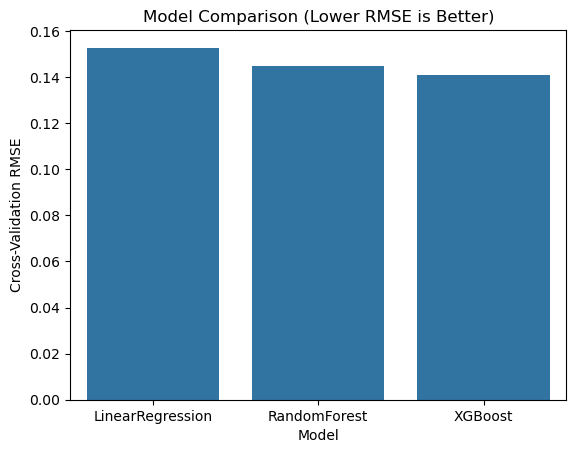

In [17]:
sns.barplot(x=results_df.index, y=results_df["CV_RMSE"])
plt.title("Model Comparison (Lower RMSE is Better)")
plt.ylabel("Cross-Validation RMSE")
plt.xlabel("Model")
plt.show()

In [21]:
results_df.to_csv("../reports/model_comparison_results.csv", index=True)